# Convergent approaches to AI Explainability for HEP muonic particles pattern recognition

# 3) Estimating Training Data Influence by Tracing Gradient Descent

The aim of this notebook is to provide an implementation of [**TracIn**](https://arxiv.org/pdf/2002.08484.pdf), a method that computes **the influence of training examples on a specific prediction made by the model** by tracing how the gradient loss on the test sample varies during the training process whenever the training examples are utilized.

## Environment setup

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
import random
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.cnn import build_cnn_tracin
from utils.metrics import spread, efficiency
from utils.plot import plot_history, plot_cm, plot_image

from tracin.tracin import get_trackin_grad, find_prop_opp

random.seed(0)

print('Libraries imported')

### Downloading data

In [2]:
# get data from my Drive, it downloads (and unzip) less stuff (i.e. only the used one) and data are already splitted
# ! rm -rf sample_data
# ! pip install --upgrade --no-cache-dir gdown -q
# ! gdown --id 1s6JZuJPAqUtnnvezDepApE4BMKo3FP4q
# print('\nUnzipping data...')
# ! unzip -q muontriggerdata-master.zip
# ! rm -rf muontriggerdata-master.zip

print('\nLoading images with noise...')
train_images = np.load('../muontriggerdata-master/train_images_with_noise.npy')
test_images = np.load('../muontriggerdata-master/test_images_with_noise.npy')

print('\nLoading images without noise...')
train_images_without_noise = np.load('../muontriggerdata-master/train_images_without_noise.npy')
test_images_without_noise = np.load('../muontriggerdata-master/test_images_without_noise.npy')

print('\nLoading labels...')
train_labels = np.load('../muontriggerdata-master/train_labels.npy')
test_labels = np.load('../muontriggerdata-master/test_labels.npy')

print('\nLoading completed.')

## Data Preprocessing

In [3]:
# checking shapes of npy arrays
print(train_images.shape)
print(test_images.shape)

print(train_images_without_noise.shape)
print(test_images_without_noise.shape)

print(train_labels.shape)
print(test_labels.shape)

In [4]:
train_labels_df = pd.DataFrame(train_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])
test_labels_df = pd.DataFrame(test_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])

Our work is focused **ONLY** on predicting values for *pt* and *eta*; therefore, we will drop the remaining parameters in the labels.

In [5]:
train_labels_df = train_labels_df.drop(columns=['phi', '0', 'nhits'])
test_labels_df = test_labels_df.drop(columns=['phi', '0', 'nhits'])

## Regression with a generic CNN

### Customized metrics definition

According to our instructions, we want a model able to select muons with $pt$ greater than a fixed threshold ($\ge 10$ GeV) with the highest possible efficiency. Moreover, it should be able to discard muons with $pt$ lower than such threshold ($< 10$ GeV).

We can do that by defining two metrics:
* **spread**, distribution of the quantity $(pt_{true} - pt_{pred})$ around the threshold of $10$ GeV (let's say $[7-8, 12-13]$ GeV). This metric should be as low as possible.
* **efficiency**, number of muons with $pt_{true} > 15$ GeV and $pt_{pred} > 15$ GeV over the number of muons with $pt_{true} > 15$ GeV. This metric should be as high as possible.

Therefore, we will create our customized metrics to be used in the ```model.compile``` method in a while.



### Definition and training

Creating a simple CNN to first solve the regression task.

In [ ]:
model = build_cnn_tracin()
model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer='sgd')
model.summary()

In [ ]:
save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpts/cnn_model_tracin/cnn_model_tracin-{epoch:02d}/cnn_model_tracin',
    save_weights_only=True,
    period=1)

history = model.fit(x=train_images,
                    y=train_labels_df,
                    batch_size=32,
                    epochs=30,
                    callbacks=[save_callback],
                    validation_data=(test_images, test_labels_df))

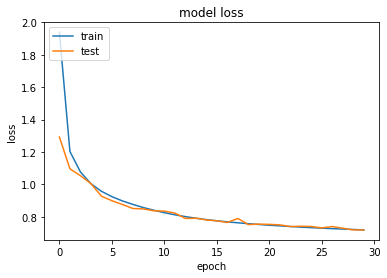

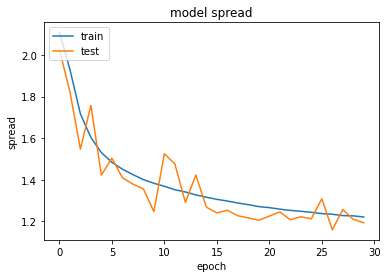

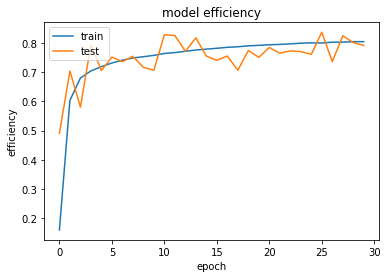

In [ ]:
plot_history(history)

### Evaluation

Evaluating such architecture.

In [6]:
model = build_cnn_tracin()
load_epoch = '26' # if < 10, write 0 before (example 2 -> 02)
model.load_weights(f'ckpts/cnn_model_tracin/cnn_model_tracin-{load_epoch}/cnn_model_tracin')

model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer='sgd')
model.evaluate(x=test_images, y=test_labels_df)

2952/2952 [==============================] - 24s 6ms/step - loss: 0.7304 - spread: 1.3126 - efficiency: 0.8370


[0.7314823865890503, 1.3092995882034302, 0.8366570472717285]

In [7]:
# inspect first 10 results
y_hat = model.predict(test_images)

pred_df = pd.DataFrame(y_hat, columns=['pt_pred', 'eta_pred'])
frames = [test_labels_df, pred_df]
compare_df = pd.concat(frames, axis=1)
compare_df.head(10)

,pt,eta,pt_pred,eta_pred
0,13.491201,0.053108,14.712338,-0.106747
1,4.227651,0.205530,4.037085,0.359133
2,13.979775,0.651565,13.109050,0.737881
3,14.510050,0.939512,12.772153,0.518033
4,10.261550,0.116171,9.395326,-0.115922
5,18.524986,0.279401,21.419334,0.227293
6,6.452104,0.492939,6.453719,0.556732
7,15.881395,0.705206,14.432706,0.721406
8,9.464007,0.130429,10.046705,0.581744
9,11.706838,0.358624,10.957355,0.320857


## Explainability by Gradient Tracing: finding Proponents and Opponents

A preliminar action we should do is to remove the images that clearly contain lots of noise and artifacts. We have found indeed that such training samples are strangely too much influent when trying to derive Proponents/Opponents.

We will remove them by selecting only images under a predefined threshold in the ```nhits``` index of the labels ($=4$).

A good threshold seems to be $17$ hits.

In [6]:
# remove "bad" images
train_bad_idxs = np.where(train_labels[:, 4] <= 17)
train_images = train_images[train_bad_idxs]
train_images_without_noise = train_images_without_noise[train_bad_idxs]
train_labels = train_labels[train_bad_idxs]

test_bad_idxs = np.where(test_labels[:, 4] <= 17)
test_images = test_images[test_bad_idxs]
test_images_without_noise = test_images_without_noise[test_bad_idxs]
test_labels = test_labels[test_bad_idxs]

#### Loading stored checkpoints

We first need to load some (let's say $3$) checkpoints saved during the previous training process.

In particular, we collect *only* the first and penultimate layers in a list and the last layer in another list.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# CKPTS_PATH = '/content/drive/MyDrive/Colab Notebooks/EAI1/ckpts/cnn_model_tracin/cnn_model_tracin-'
CKPTS_PATH = 'ckpts/cnn_model_tracin/cnn_model_tracin-'
models_penultimate = []
models_last = []
for i in ['05', '15', '25']:
    model = build_cnn_tracin()
    model.load_weights(f'{CKPTS_PATH}{i}/cnn_model_tracin')
    models_penultimate.append(Model(model.layers[0].input, model.layers[-2].output))
    models_last.append(model.layers[-1])
    model = None

#### Find Proponents and Opponents for a given test example

Then, we will compute the loss gradient for each sample in the training test.

When we will find the Proponents and the Opponents for a desired test image, we will take the ```topk``` greatest and lowest values of gradient associated to every train image.

Computing the *TrackIn* information for each sample of train and test.

In [10]:
bs = 32

trackin_train = get_trackin_grad(models_penultimate, models_last, train_images, train_labels, batch_size=bs)
trackin_test = get_trackin_grad(models_penultimate, models_last, test_images, test_labels, batch_size=bs)

Batch TrackIn: 100%|██████████| 2568/2568 [00:43<00:00, 58.72it/s]


### Interesting study cases:

We can now analyze specific test images and observe the most influent Proponents and Opponents.

With each plot, one can also notice the real and predicted values together with the influence, the error and the encoding similarity.

#### a. Selected events inspection

We can now inspect specific correctly or wrongly selected images and provide the related explanations from the network.
Note that we have a correct selection when the model predicts a $pt_{pred} > 15$ GeV given that $pt_{true} > 15$ GeV.

We can do that by first constructing a "*confusion matrix*" with the ```True/False Positives/Negatives``` events and then inspect each of these classification regions.

In [11]:
model = build_cnn_tracin()
load_epoch = '25' # if < 10, write 0 before (example 2 -> 02); use the last of the 3 picked models
model.load_weights(f'ckpts/cnn_model_tracin/cnn_model_tracin-{load_epoch}/cnn_model_tracin')

model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer='sgd')

y_hat = model.predict(test_images)
pred_df = pd.DataFrame(y_hat, columns=['pt_pred', 'eta_pred'])

test_labels_df = pd.DataFrame(test_labels, columns=['pt', 'eta', 'phi', '0', 'nhits'])
test_labels_df = test_labels_df.drop(columns=['phi', '0', 'nhits'])

frames = [test_labels_df, pred_df]
compare_df = pd.concat(frames, axis=1)

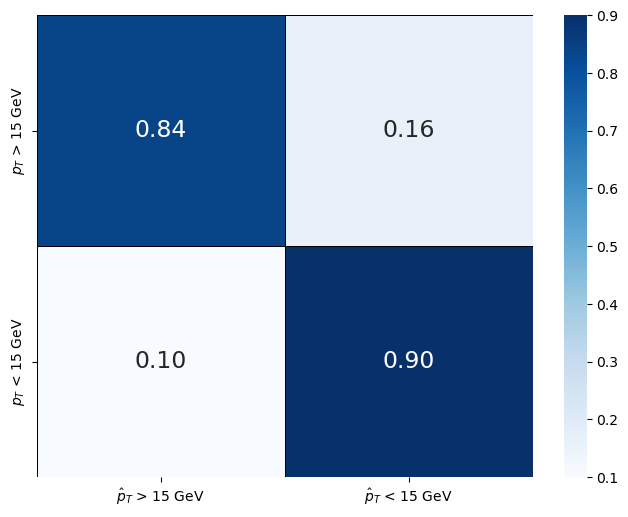

In [28]:
tp_index, fn_index, fp_index, tn_index, cm_plot = plot_cm(compare_df)

##### a.1. Correctly selected events inspection

Let's now evaluate the explanations of the network with the correctly selected images (i.e. where particles have **both** actual and predicted $pt >$ or $< 15$ GeV).

Test image [68415]:


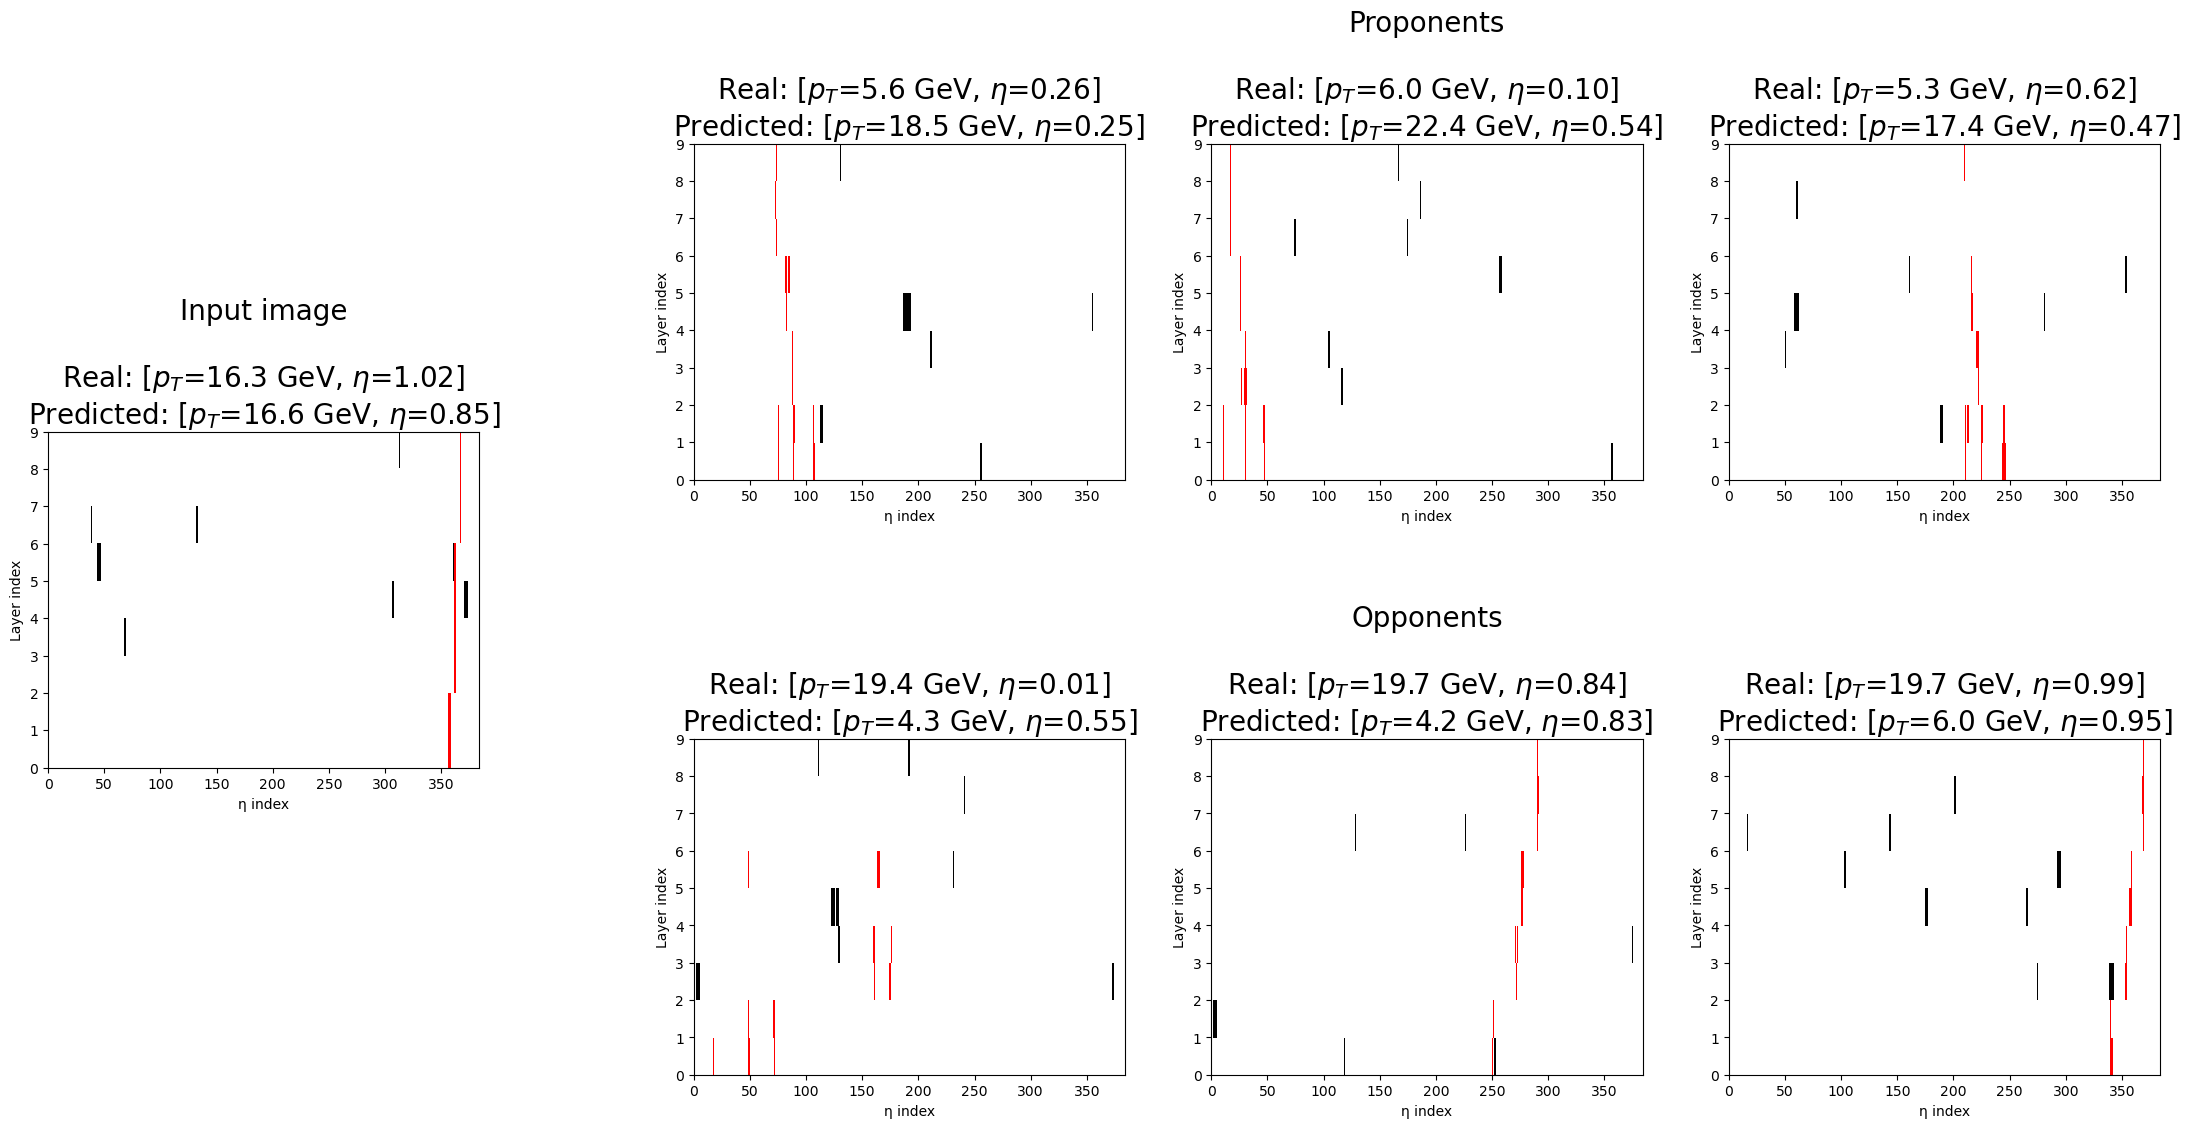

Proponents indices:  [486532, 156275, 588872]
Opponents indices:  [64903, 520621, 200021]


In [16]:
idx = random.sample(tp_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, test_images, test_images_without_noise, topk=3, title='tp.jpg')

Test image [9247]:


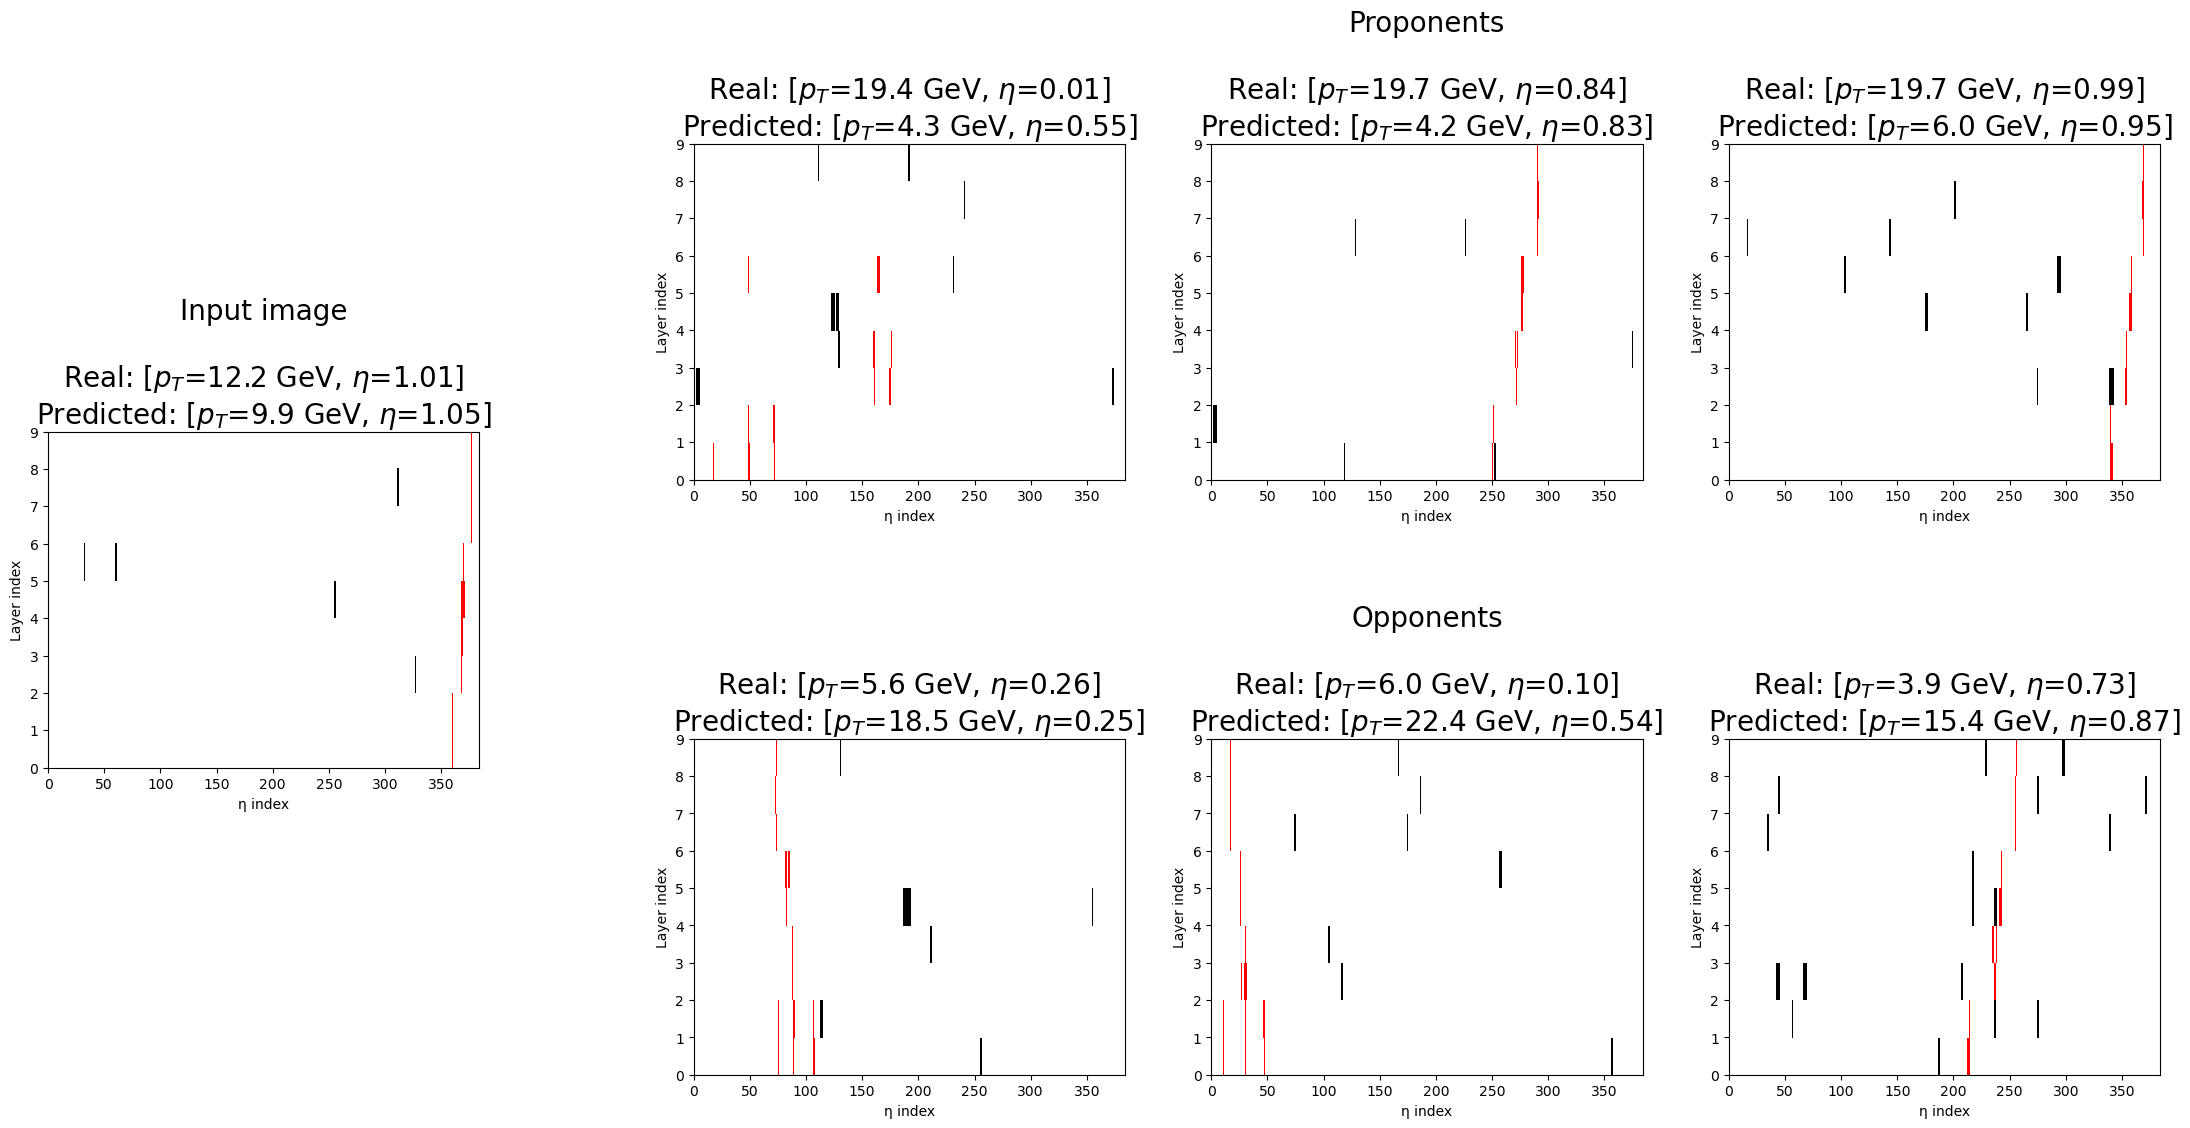

Proponents indices:  [64903, 520621, 200021]
Opponents indices:  [486532, 156275, 620559]


In [17]:
idx = random.sample(tn_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, test_images, test_images_without_noise, topk=3, title='tn.jpg')

##### a.2. Wrongly selected events inspection

Consequently, it is crucial to analyze the case where the network is wrong, namely it predicts a $pt_{pred} > 15$ GeV for images with a $pt_{true}$ under the threshold of interest of $10$ GeV and viceversa.

In particular, we focus on cases where the model error is higher than usual; as instance, filtering only when $|pt_{true} - pt_{pred}| > 10$ GeV.

Test image [44088]:


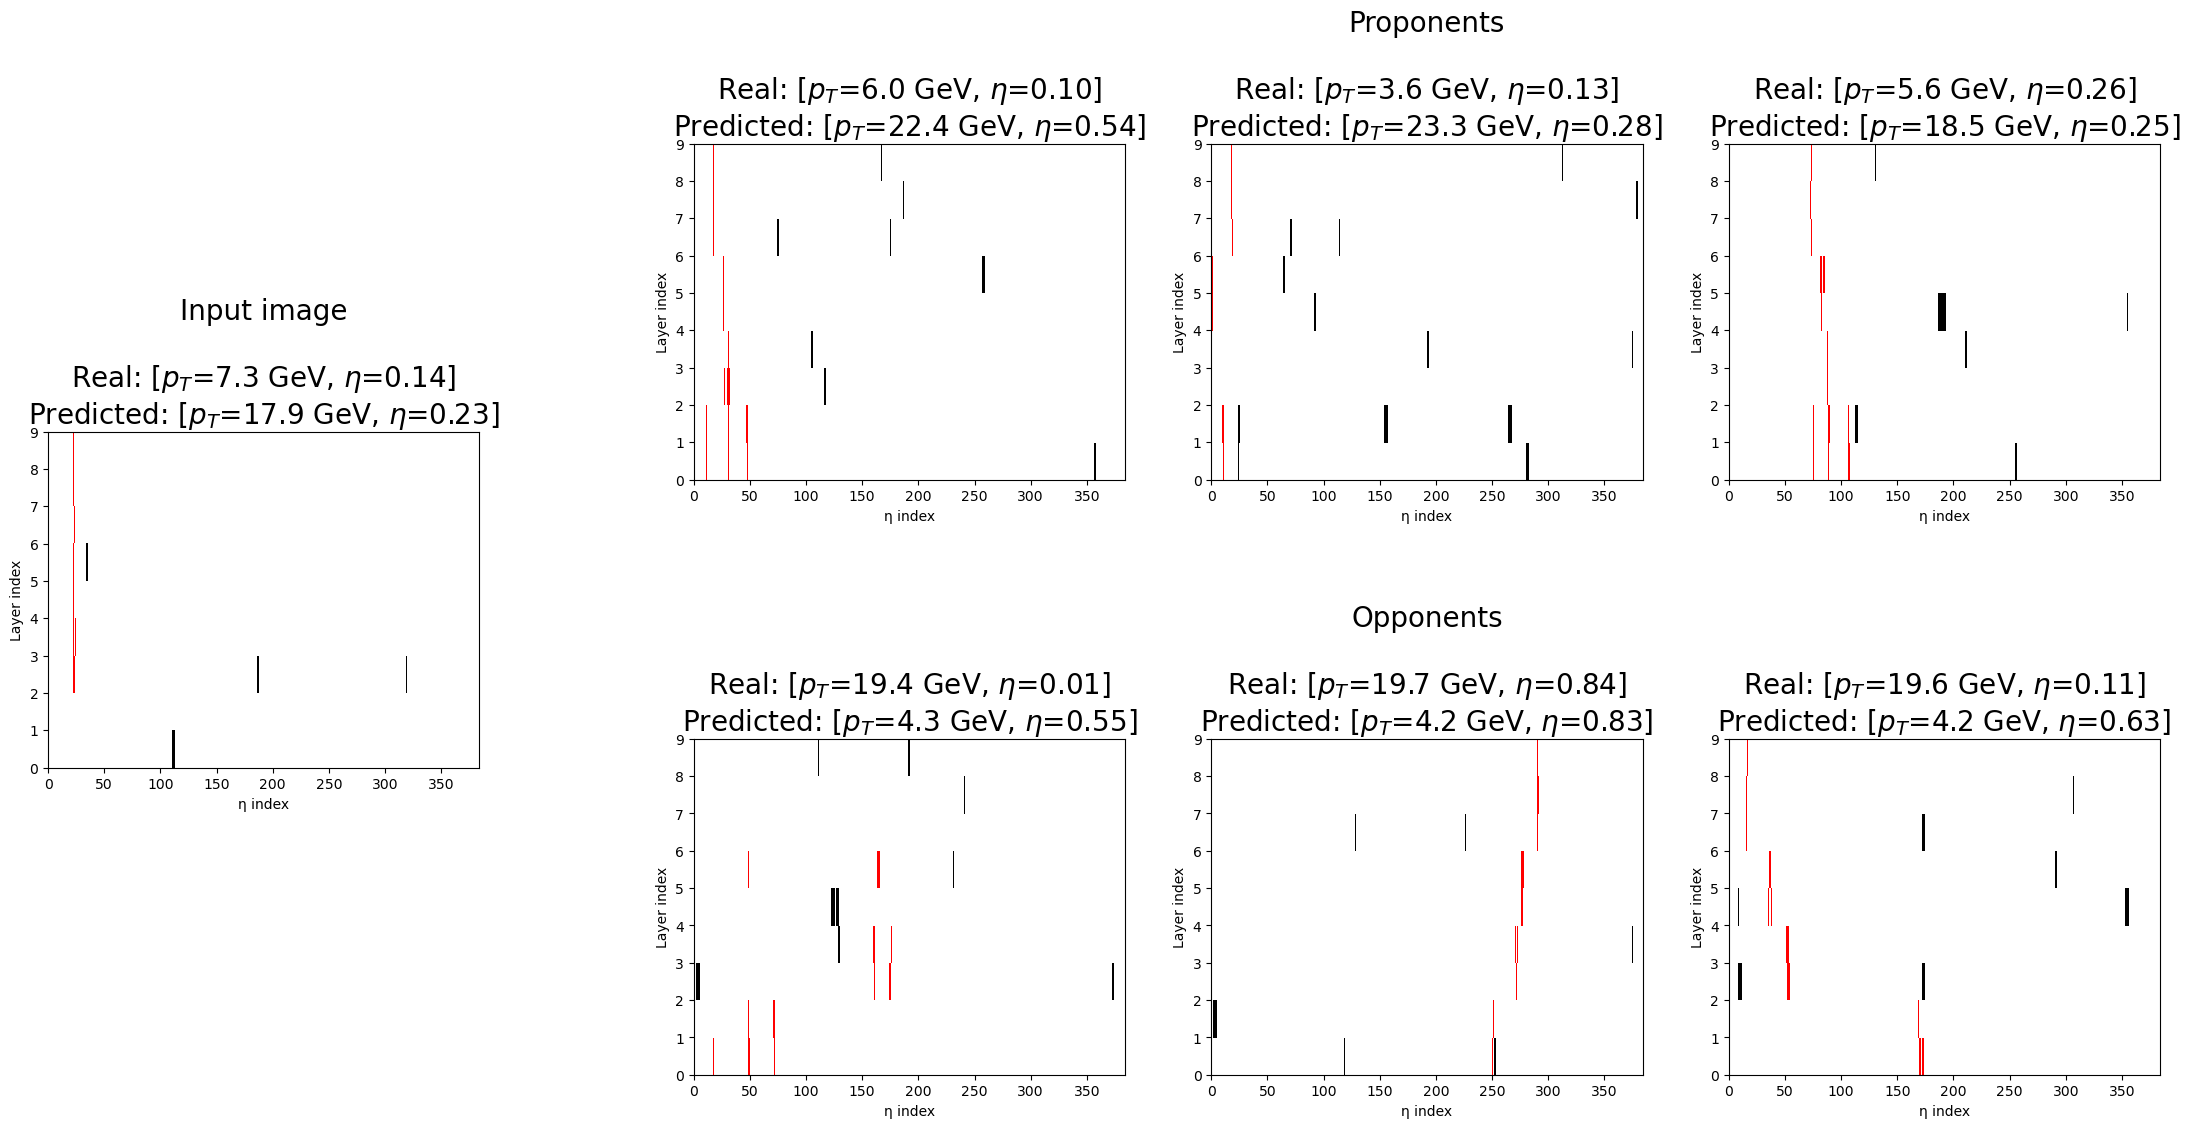

Proponents indices:  [156275, 630785, 486532]
Opponents indices:  [64903, 520621, 133152]


In [18]:
idx = random.sample(fp_index, 1)[0]
while abs(compare_df.iat[idx, 0] - compare_df.iat[idx, 2]) < 10:
    idx = random.choice(fp_index)
    
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, test_images, test_images_without_noise, topk=3, title='fp.jpg')

Test image [45366]:


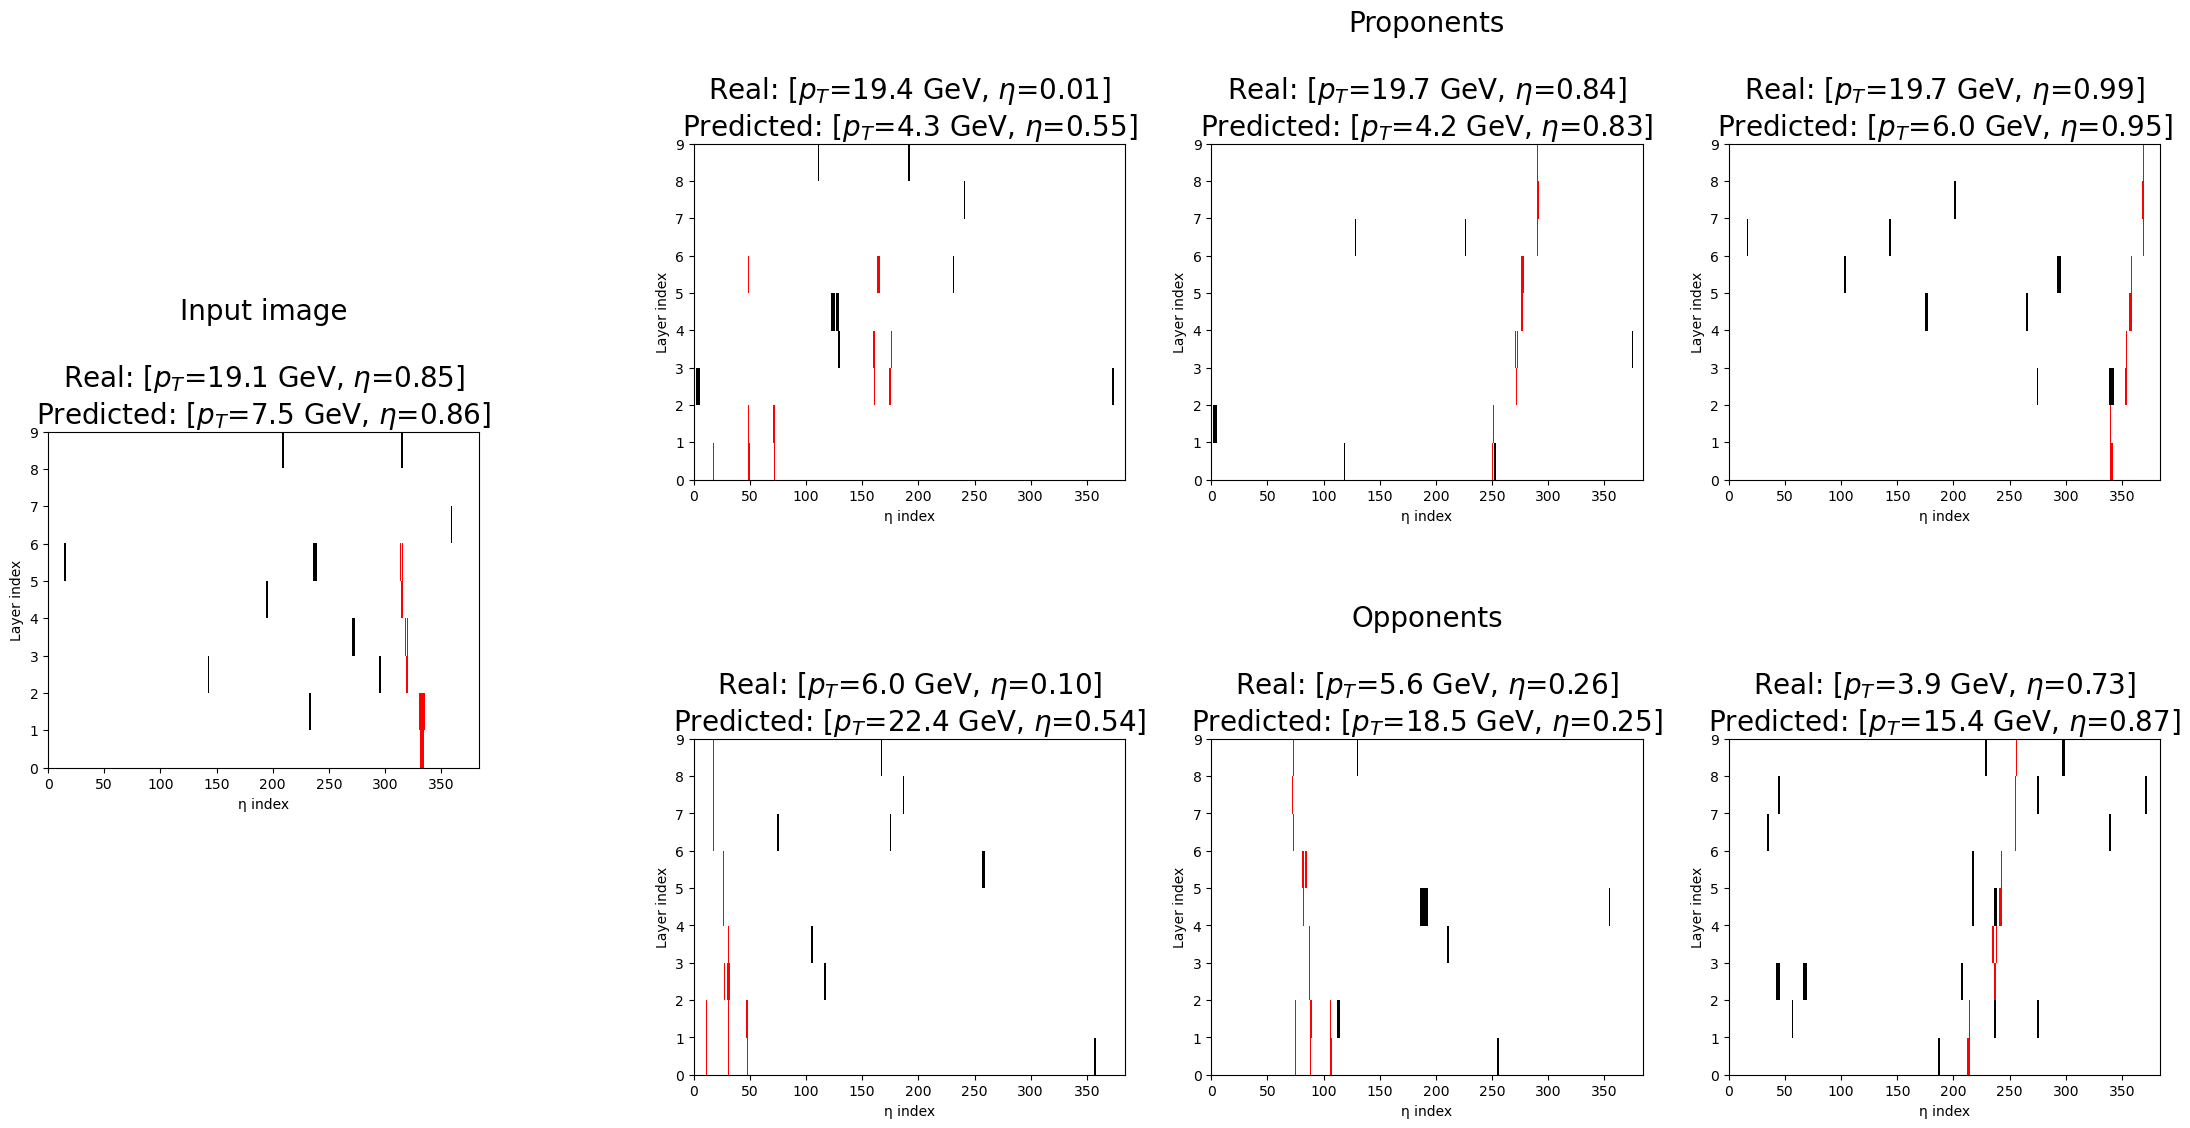

Proponents indices:  [64903, 520621, 200021]
Opponents indices:  [156275, 486532, 620559]


In [19]:
idx = random.sample(fn_index, 1)[0]
while abs(compare_df.iat[idx, 0] - compare_df.iat[idx, 2]) < 10:
    idx = random.choice(fn_index)

find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, test_images, test_images_without_noise, topk=3, title='fn.jpg')

#### b. Only-noise images inspection

Finally, it's very interesting to see how the network behaves with images containing only noise and no effective patterns of the particles.

In [20]:
# what does the model predict for only-noise images?
# how many of them are predicted with a pt>10 GeV? Inspect them
# ! gdown --id 1nKHHj6ZqbS1SGkH5OYpezbYujbRlXxsi
# print('\nUnzipping data...')
# ! unzip -q images_only_noise.zip
# ! rm -rf images_only_noise.zip

print('\nLoading only-noise images...')
noise_images = np.load('../images_only_noise/images_only_noise.npy')
noise_labels = np.zeros((len(noise_images), 2))
print('\nLoading completed.')

In [14]:
model = build_cnn_tracin()
load_epoch = '25' # if < 10, write 0 before (example 2 -> 02)
model.load_weights(f'ckpts/cnn_model_tracin/cnn_model_tracin-{load_epoch}/cnn_model_tracin')

model.compile(loss='mae',
              metrics=[spread, efficiency],
              optimizer='sgd')

# predicting only-noise images
noise_y_hat = model.predict(noise_images)
noise_df = pd.DataFrame(noise_y_hat, columns=['pt_pred', 'eta_pred'])

Computing the *TrackIn* information for each sample of train and only-noise datasets.

In [21]:
bs = 32

trackin_train = get_trackin_grad(models_penultimate, models_last, train_images, train_labels, batch_size=bs)
trackin_test = get_trackin_grad(models_penultimate, models_last, noise_images, noise_labels, batch_size=bs)

Batch TrackIn: 100%|██████████| 29514/29514 [08:20<00:00, 58.96it/s]


In [24]:
# let us consider those with pt > 10 GeV
onlyNoise_index = []
for i, elem in noise_df.iterrows():
    if elem['pt_pred'] > 10:
        onlyNoise_index.append(i)
print(f'There are {len(onlyNoise_index)} selected events among the only-noise images. {len(onlyNoise_index)/len(noise_images)*100:0.4f}%')

There are 11 selected events among the only-noise images. 0.0012%


Test image [602218]:


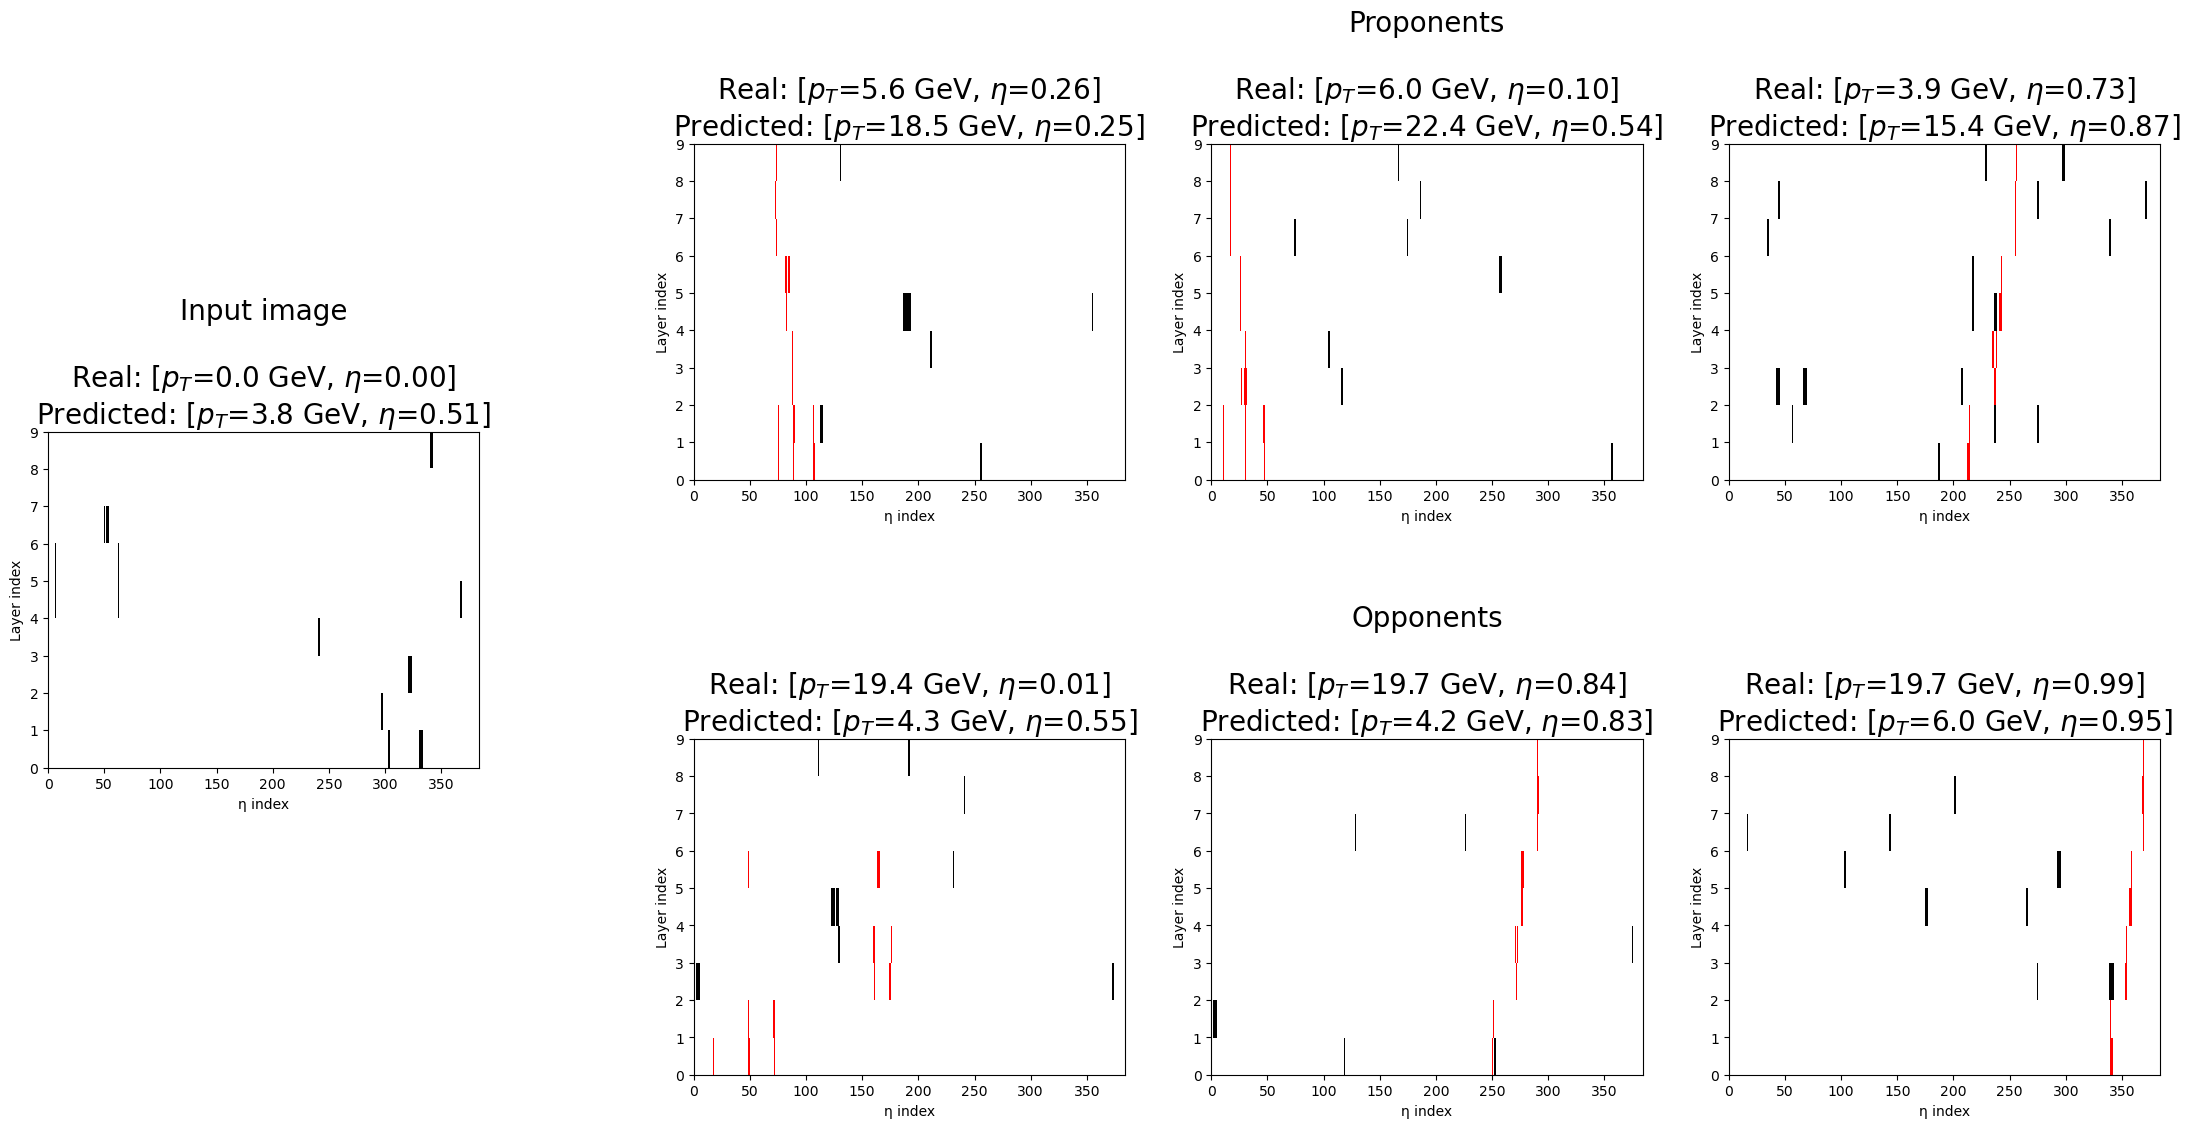

Proponents indices:  [486532, 156275, 620559]
Opponents indices:  [64903, 520621, 200021]


In [24]:
# only-noise predicted < 4 GeV (only 1 sample)
idx = random.sample(onlyNoise_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, noise_images, None, topk=3, title='noise_low.jpg')

Test image [471096]:


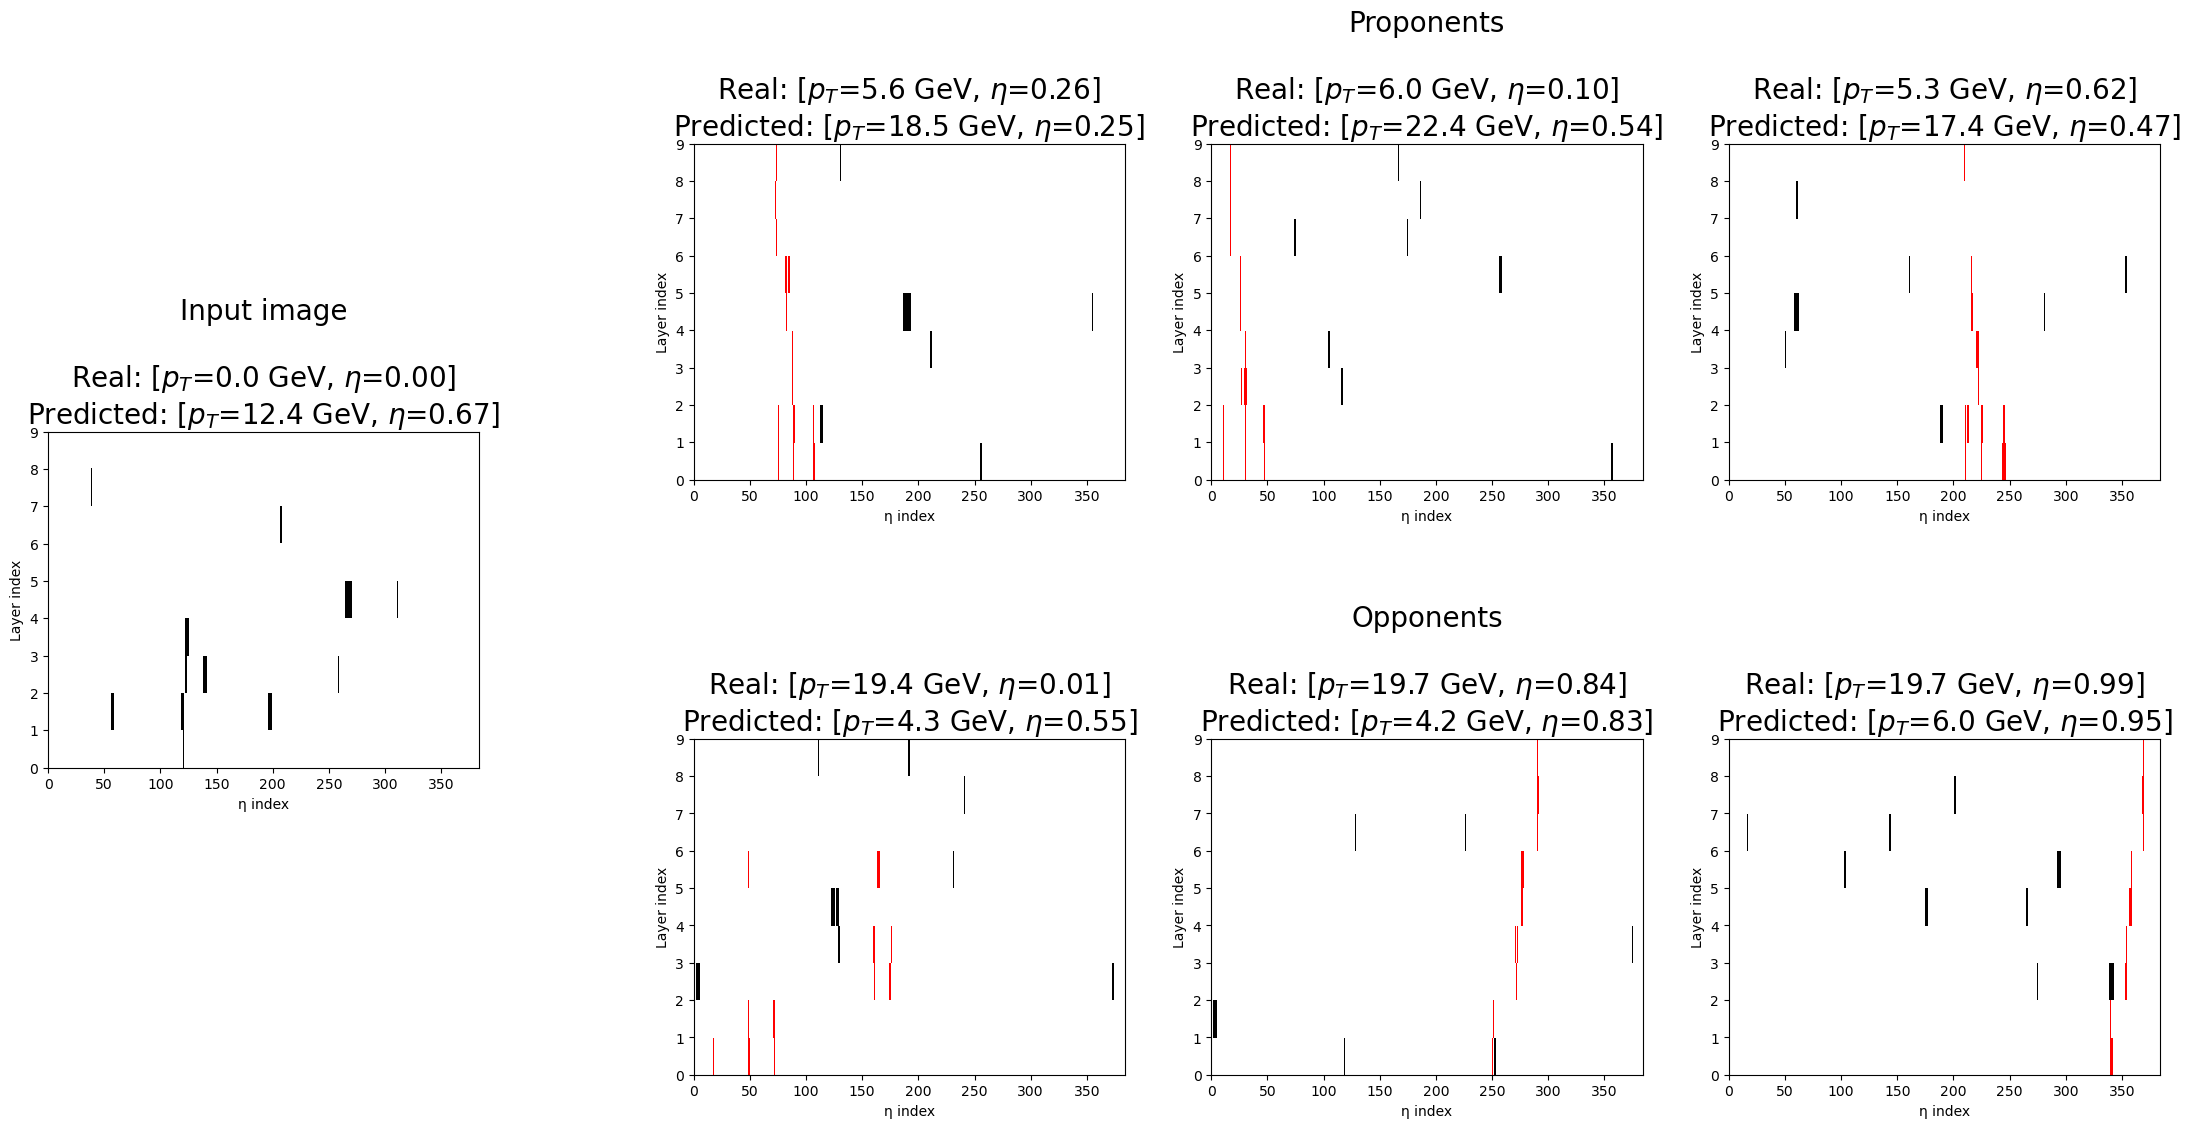

Proponents indices:  [486532, 156275, 588872]
Opponents indices:  [64903, 520621, 200021]


In [25]:
# only-noise predicted > 10 GeV
idx = random.sample(onlyNoise_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, noise_images, None, topk=3, title='noise_high1.jpg')

Test image [558669]:


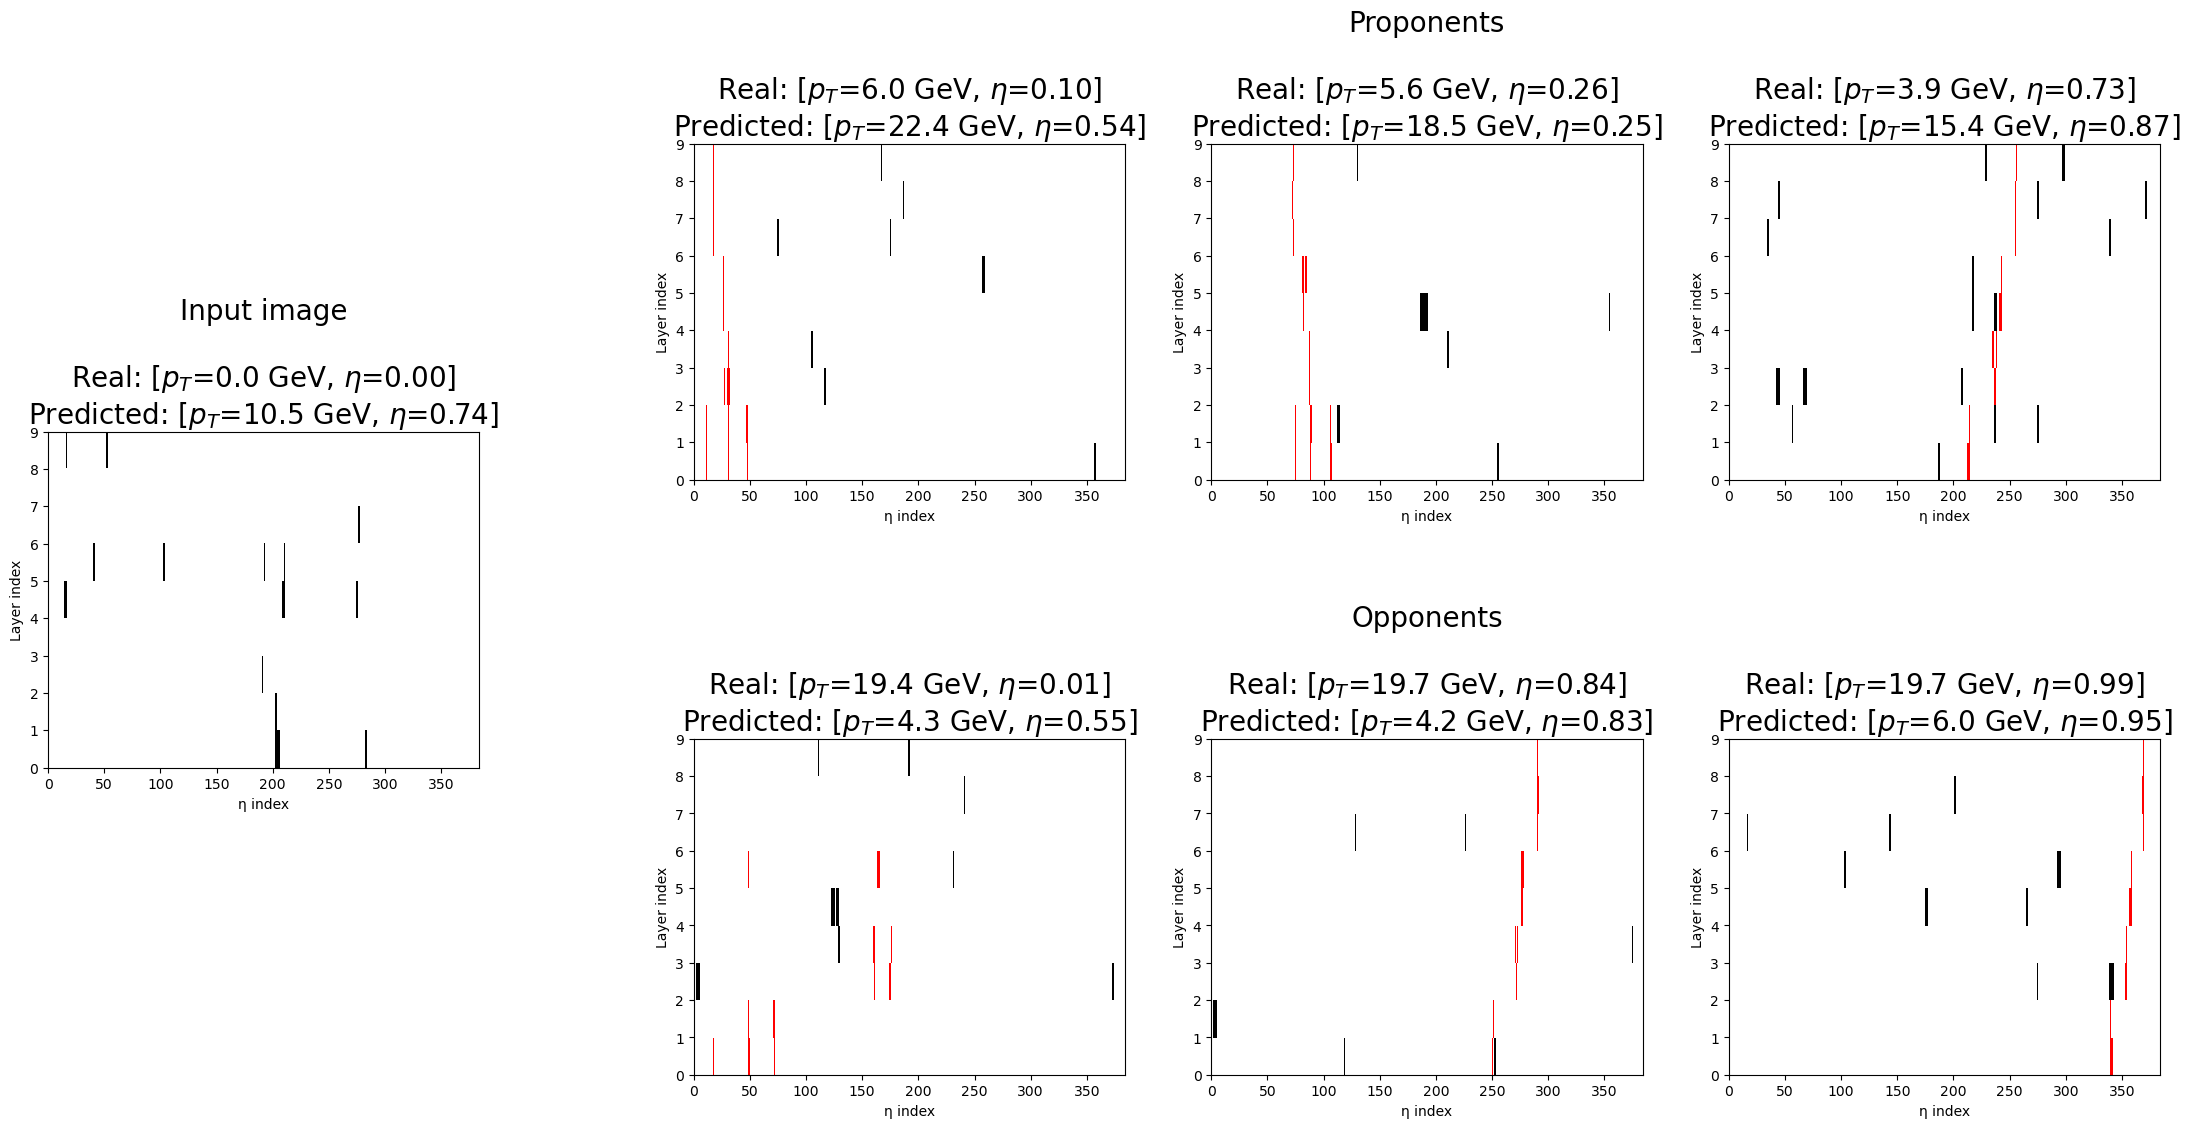

Proponents indices:  [156275, 486532, 620559]
Opponents indices:  [64903, 520621, 200021]


In [26]:
# only-noise predicted > 10 GeV
idx = random.sample(onlyNoise_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, noise_images, None, topk=3, title='noise_high2.jpg')

Test image [60643]:


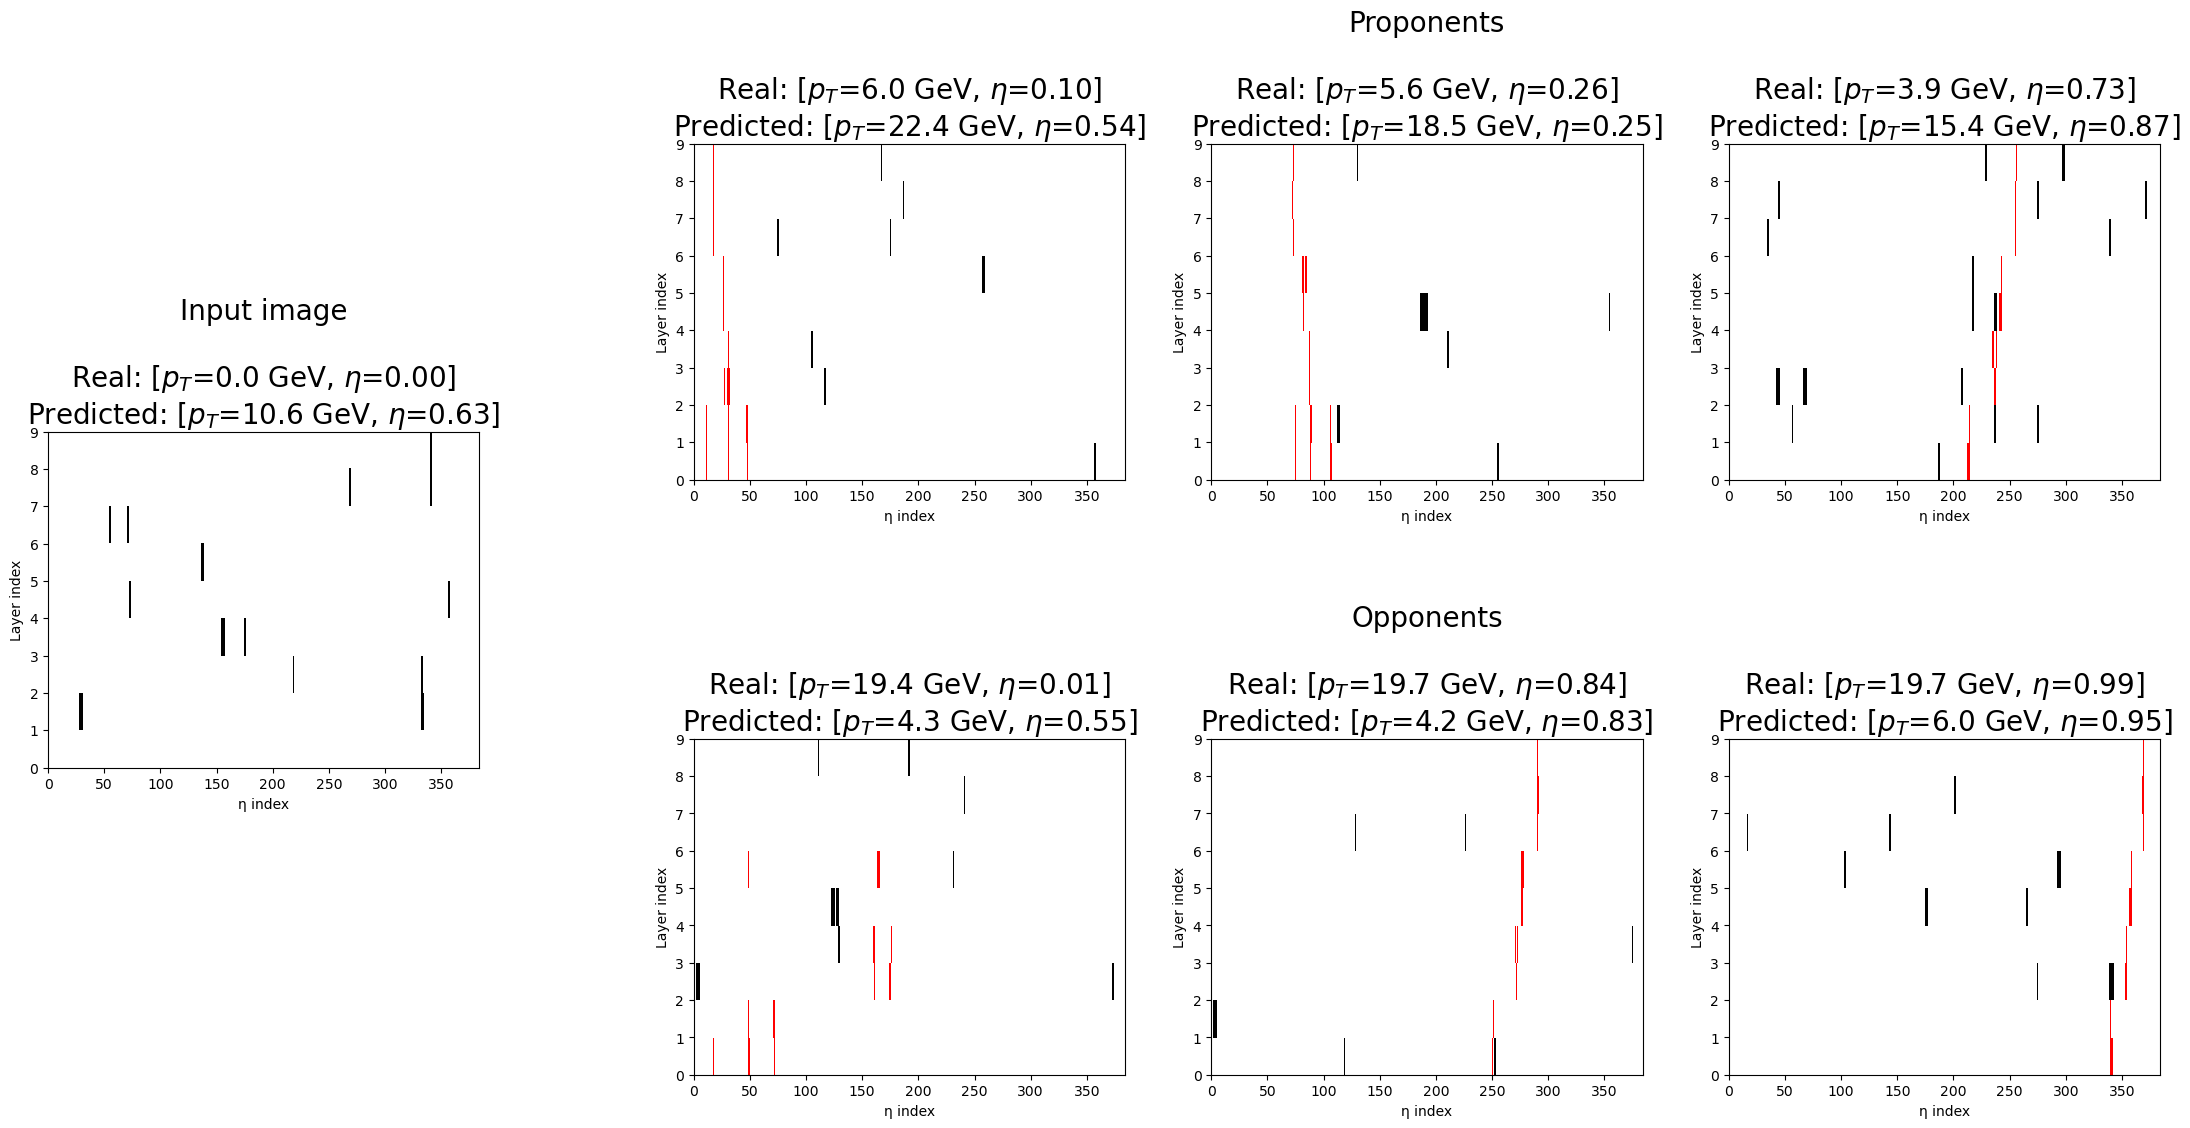

Proponents indices:  [156275, 486532, 620559]
Opponents indices:  [64903, 520621, 200021]


In [27]:
# only-noise predicted > 10 GeV
idx = random.sample(onlyNoise_index, 1)[0]
find_prop_opp(trackin_train, trackin_test, idx, train_images, train_images_without_noise, noise_images, None, topk=3, title='noise_high3.jpg')